<a href="https://colab.research.google.com/github/dfridland/PyTorch/blob/HW6/PyTorchHW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls -lha kaggle.json

ls: cannot access 'kaggle.json': No such file or directory


In [2]:
!pip install -q kaggle

In [3]:
 from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dianafridlyand","key":"eb50b0058efb905468066fe811db57cd"}'}

In [5]:
!mkdir -p ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [9]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

 53% 1.00M/1.89M [00:00<00:00, 1.99MB/s]
100% 1.89M/1.89M [00:00<00:00, 3.25MB/s]


In [30]:
!pip install stop-words pymorphy2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=51c989f4e71a9f61479881e521a1f91e4eb9bf3b6e91512224623527161b1003
  Stored in directory: /root/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=6ce3f403632f563a1042e832094b6991ae94049f1d5540c1e3836af714203272
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built stop-words docopt


In [31]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

from string import punctuation
#from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from sklearn.model_selection import train_test_split

from tqdm import tqdm 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [106]:
max_words = 2000
max_len = 15
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [12]:
!unzip /content/twitter-sentiment-analysis-hatred-speech.zip -d Twittdataset
     

Archive:  /content/twitter-sentiment-analysis-hatred-speech.zip
  inflating: Twittdataset/test.csv   
  inflating: Twittdataset/train.csv  


In [56]:
import pandas as pandas
df_train = pd.read_csv('./Twittdataset/train.csv')
df_test = pd.read_csv('./Twittdataset/test.csv')

In [107]:
df_train.head()

,id,label,tweet
19010,19011,0,weekend
5474,5475,0,world really going bonkers really bad atm shoo...
6557,6558,0,made night hahahha
3617,3618,0,shes looking like really good person stupid am...
5099,5100,0,must first year ever xbox playstation killed e...


In [108]:
df_train['label'].value_counts()

0    22288
1     1683
Name: label, dtype: int64

In [109]:
df_test.tail()

,id,tweet
17192,49155,thought factory leftright polarisation trump u...
17193,49156,feeling like mermaid ð hairflip neverready ...
17194,49157,hillary campaigned today ohioomg amp used word...
17195,49158,happy work conference right mindset leads cult...
17196,49159,song glad free download shoegaze newmusic newsong


In [110]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)

In [111]:
df_train.shape, df_val.shape

((17978, 3), (5993, 3))

In [112]:
#df_val['label'].value_counts()

In [ ]:
sw = set(get_stop_words('en'))
sw

In [ ]:
puncts = set(punctuation)
puncts

In [43]:
# morpher = MorphAnalyzer()
# morpher.parse('cooked')[0].normal_form
     

In [115]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
  txt = str(txt)
  txt = ''.join(c for c in txt if c not in puncts)
  txt = txt.lower()
  txt = re.sub(r".?\\[\w|\d]*", "", txt)
  txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
  return ' '.join(txt)

In [116]:
df_train['tweet'].iloc[:5].values

array(['interstellar really hits feels',
       'words needed love peace respect',
       'large general s gbp 990 get shop cool home fun',
       'award winning chilli sauces ð\x9f\x98\x8dð\x9f\x8f\x86 celebrate chillisauceâ\x80¦',
       'mindsconsole best way avoid disappointment expect anything anyone motivation'],
      dtype=object)

In [117]:
df_train['tweet'].iloc[:5].apply(preprocess_text).values

array(['interstellar really hits feels',
       'words needed love peace respect',
       'large general s gbp 990 get shop cool home fun',
       'award winning chilli sauces ð\x9f\x98\x8dð\x9f\x8f\x86 celebrate chillisauceâ\x80¦',
       'mindsconsole best way avoid disappointment expect anything anyone motivation'],
      dtype=object)

In [118]:
tqdm.pandas()

In [119]:
df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)

df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:03<00:00, 4831.91it/s]


In [120]:
train_corpus = ''.join(df_train['tweet'])
train_corpus = train_corpus.lower()

In [121]:
nltk.download('punkt')
tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['interstellar', 'really', 'hits', 'feelswords', 'needed']

In [122]:
token_filtered = [word for word in tokens if word.isalnum()]

In [123]:
dist = FreqDist(token_filtered)
token_filtered_top = [pair[0] for pair in  dist.most_common(max_words-1)]
len(token_filtered_top)

1999

In [124]:
token_filtered_top[:10]

['user', 'love', 'day', 'amp', 'will', 'u', 'time', 'just', 'happy', 'like']

In [125]:
vocabulary = {v: k for k, v in dict(enumerate(token_filtered_top, 1)).items()}
# vocabulary

In [126]:
def text_to_sequence(text, maxlen):
  result=[]
  tokens = word_tokenize(text.lower())
  tokens_filtered = [word for word in tokens if word.isalnum()]
  for word in tokens_filtered:
    if word in vocabulary:
      result.append(vocabulary[word])
  padding = [0] * (maxlen - len(result))
  return result[-maxlen:] + padding

In [127]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train['tweet']])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val['tweet']])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])

CPU times: user 4.29 s, sys: 10.6 ms, total: 4.3 s
Wall time: 4.32 s


In [128]:
x_train.shape

(17978, 15)

In [129]:
df_train['tweet'].iloc[:5]

11307                       interstellar really hits feels
23820                      words needed love peace respect
20561       large general s gbp 990 get shop cool home fun
24218    award winning chilli sauces ðð celebrate...
27194    mindsconsole best way avoid disappointment exp...
Name: tweet, dtype: object

In [130]:
x_train[:5]

array([[  52, 1324,  610,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 334,  737,    2,  155,  886,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 367,  583,   13,  309,  203,   62,   37,    0,    0,    0,    0,
           0,    0,    0,    0],
       [1381, 1249,  374,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  55,   44, 1796, 1250,  359,  421,  336,    0,    0,    0,    0,
           0,    0,    0,    0]])

In [131]:
class Net(nn.Module):
  def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.conv_1= nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
    self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
    self.dro = nn.Dropout(0.2)
    self.pool = nn.MaxPool1d(2)
    self.relu=nn.ReLU()
    self.linear_1 = nn.Linear(out_channel, out_channel // 2)
    self.linear_2 = nn.Linear(out_channel // 2, num_classes)

  def forward(self, x):
    output = self.embedding(x) 
    output = output.permute(0,2,1)

    output = self.conv_1(output)
    output = self.dro(output)
    output = self.relu(output)
    output = self.pool(output)
    output = self.conv_2(output)
    output = self.dro(output)
    output = self.relu(output)
    output = self.pool(output)
    output = torch.max(output, axis=2).values
    output = self.linear_1(output)
    output = self.relu(output)
    output = self.linear_2(output)
    output = F.sigmoid(output)
    return output

In [132]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [133]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [134]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 15])
torch.Size([512])
tensor(0)


In [135]:
model = Net(vocab_size=max_words)

In [136]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (dro): Dropout(p=0.2, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [137]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()    

In [138]:
model = model.to(device)
model.train()
th=0.5

train_loss_history = []
test_loss_history = []

for epoch in range(epochs):
  running_items, running_right = 0.0, 0.0
  for i, data in enumerate (train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(outputs, labels.float().view(-1, 1))
    loss.backward()
    optimizer.step()

    loss = loss.item()
    running_items += len(labels)
    pred_labels = torch.squeeze((outputs > th).int())
    running_right += (labels == pred_labels).sum()

    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/5]. Step [1/36]. Loss: 0.689. Acc: 0.574. Test loss: 0.000. Test acc: 0.926
Epoch [1/5]. Step [2/36]. Loss: 0.582. Acc: 0.928. Test loss: 0.082. Test acc: 0.926
Epoch [1/5]. Step [3/36]. Loss: 0.255. Acc: 0.928. Test loss: 0.212. Test acc: 0.926
Epoch [1/5]. Step [4/36]. Loss: 0.267. Acc: 0.959. Test loss: 2.008. Test acc: 0.926
Epoch [1/5]. Step [5/36]. Loss: 0.294. Acc: 0.920. Test loss: 0.029. Test acc: 0.926
Epoch [1/5]. Step [6/36]. Loss: 0.255. Acc: 0.936. Test loss: 0.018. Test acc: 0.926
Epoch [1/5]. Step [7/36]. Loss: 0.247. Acc: 0.941. Test loss: 0.007. Test acc: 0.926
Epoch [1/5]. Step [8/36]. Loss: 0.303. Acc: 0.924. Test loss: 0.031. Test acc: 0.926
Epoch [1/5]. Step [9/36]. Loss: 0.227. Acc: 0.936. Test loss: 0.051. Test acc: 0.926
Epoch [1/5]. Step [10/36]. Loss: 0.217. Acc: 0.936. Test loss: 0.151. Test acc: 0.926
Epoch [1/5]. Step [11/36]. Loss: 0.227. Acc: 0.938. Test loss: 0.077. Test acc: 0.926
Epoch [1/5]. Step [12/36]. Loss: 0.234. Acc: 0.938. Test loss: 

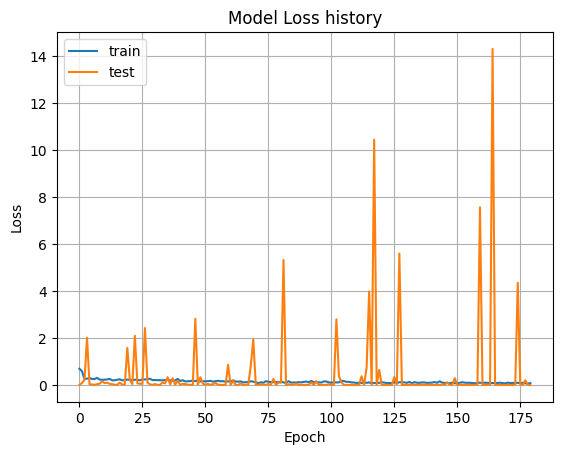

In [140]:
import matplotlib.pyplot as plt

plt.title('Model Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()